In [2]:
import os
import pandas as pd
import tensorflow as tf 
import numpy as np

In [3]:
df = pd.read_csv(os.path.join('train', 'train.csv'))

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
from tensorflow.keras.layers import TextVectorization

In [6]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [7]:
MAX_WORDS = 200000 # number of words in the vocab 

In [8]:
vectorizer = TextVectorization(max_tokens=MAX_WORDS,
                               output_sequence_length=1800,
                               output_mode='int')

In [9]:
vectorizer.adapt(X.values)

In [10]:
vectorized_text = vectorizer(X.values)

In [11]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [13]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [15]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_WORDS+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [20]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [22]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
6981/6981 [==============================] - 617s 88ms/step - loss: 0.0450 - accuracy: 0.9941 - val_loss: 0.0404 - val_accuracy: 0.9937
Epoch 2/10
6981/6981 [==============================] - 612s 88ms/step - loss: 0.0400 - accuracy: 0.9935 - val_loss: 0.0344 - val_accuracy: 0.9932
Epoch 3/10
6981/6981 [==============================] - 610s 87ms/step - loss: 0.0354 - accuracy: 0.9939 - val_loss: 0.0311 - val_accuracy: 0.9940
Epoch 4/10
6981/6981 [==============================] - 609s 87ms/step - loss: 0.0318 - accuracy: 0.9944 - val_loss: 0.0286 - val_accuracy: 0.9948
Epoch 5/10
6981/6981 [==============================] - 611s 88ms/step - loss: 0.0283 - accuracy: 0.9935 - val_loss: 0.0251 - val_accuracy: 0.9920
Epoch 6/10
6981/6981 [==============================] - 611s 88ms/step - loss: 0.0257 - accuracy: 0.9927 - val_loss: 0.0233 - val_accuracy: 0.9913
Epoch 7/10
6981/6981 [==============================] - 611s 87ms/step - loss: 0.0234 - accuracy: 0.9921 - val_loss: 0

In [23]:
from matplotlib import pyplot as plt 

<Figure size 576x360 with 0 Axes>

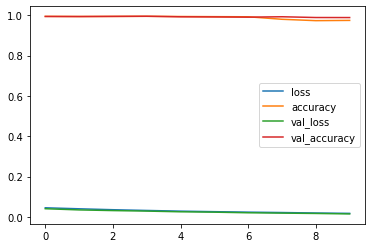

In [42]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [28]:
input_text = vectorizer('You freaking suck! I am going to hit you.')
input_text = np.expand_dims(input_text, 0)

In [29]:
res = model.predict(input_text)
res

1/1 [==============================] - 1s 693ms/step


array([[0.9981053 , 0.3114897 , 0.9714982 , 0.05398708, 0.8943353 ,
        0.08774459]], dtype=float32)

In [30]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [31]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [32]:
(model.predict(batch_X) > 0.5).astype(int)   

1/1 [==============================] - 0s 65ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [33]:
res.shape

(1, 6)

In [34]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy 

In [35]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [36]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 50ms/step


In [37]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9217795729637146, Recall:0.9282577037811279, Accuracy:0.5185556411743164


In [38]:
!pip install -q gradio

     |████████████████████████████████| 11.6 MB 31.6 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 2.3 MB 56.4 MB/s 
     |████████████████████████████████| 213 kB 77.6 MB/s 
     |████████████████████████████████| 106 kB 77.8 MB/s 
     |████████████████████████████████| 55 kB 2.5 MB/s 
     |████████████████████████████████| 84 kB 4.3 MB/s 
     |████████████████████████████████| 56 kB 5.0 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 
     |████████████████████████████████| 278 kB 75.2 MB/s 
     |████████████████████████████████| 64 kB 3.3 MB/s 
     |████████████████████████████████| 80 kB 9.6 MB/s 
     |████████████████████████████████| 68 kB 8.4 MB/s 
     |████████████████████████████████| 68 kB 7.5 MB/s 
     |████████████████████████████████| 68 kB 7.3 MB/s 
     |████████████████████████████████| 68 kB 8.2 MB/s 
     |████████████████████████████████| 50 kB 7.2 MB/s 
     |███████████████████████████████

In [39]:
import tensorflow as tf
import gradio as gr

In [40]:
model.save('toxicity.h5')

In [41]:
from google.colab import files
files.download('toxicity.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
model = tf.keras.models.load_model('toxicity.h5')

In [44]:
input_str = vectorizer('hey i freaken hate you!')

In [45]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 640ms/step


In [46]:
res

array([[8.5435218e-01, 6.8911916e-04, 3.5353899e-02, 1.4093736e-03,
        1.1272330e-01, 3.1614180e-03]], dtype=float32)

In [47]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [48]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

/usr/local/lib/python3.8/dist-packages/gradio/inputs.py:26: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [49]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://adfe4e4cdfbfc5f6.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
